**RaVAEn on KV260 (PS)** 

In [31]:
!pip install rasterio
!pip install pandas


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
channel = 10

# Load data

In [33]:
# # @title Init data functions
# d=['floods','hurricanes','fires']
# s=[['s1','s2','s3','s4'],['s1','s2','s3','s4','s5'],['s1','s2','s3','s4','s5']]
# t=[[['2017-11-18','2017-11-30','2017-12-03','2017-12-05','2017-12-13'],['2017-12-30','2018-01-19','2018-01-29','2018-02-08','2018-02-28'],['2018-09-20','2018-09-25','2018-09-30','2018-10-05','2018-10-20'],['2018-10-20','2018-10-23','2018-10-25','2018-10-30','2018-11-04']],
# [['2019-07-07','2019-07-17','2019-07-27','2019-08-16','2019-09-05'],['2017-06-16','2017-07-08','2017-07-26','2017-08-15','2017-08-30'],['2017-07-06','2017-08-05','2017-08-15','2017-08-25','2017-09-24'],['2017-07-24','2017-08-13','2017-08-18','2017-08-23','2017-10-02'],['2018-09-29','2018-10-02','2018-10-04','2018-10-07','2018-10-14']],
# [['2018-10-17','2018-10-22','2018-10-27','2018-11-06','2018-12-06'],['2018-07-12','2018-07-17','2018-07-22','2018-07-27','2018-08-11'],['2020-07-28','2020-08-02','2020-08-07','2020-08-12','2020-09-06'],['2019-11-21','2019-12-16','2019-12-21','2019-12-26','2020-01-25'],['2018-12-06','2018-12-11','2018-12-26','2018-12-31','2019-02-24']]]

# a=d[2]
# # b=s[1][0]
# # c=t[1][0][0]
# for i in range(5):
#     b = s[2][i]
#     for c in t[2][i]:
import fsspec
import glob
import numpy as np
import rasterio
import os
from torch.utils.data import Dataset

def load_all_tile_indices_from_folder(settings_dataset):
    path = settings_dataset["data_base_path"]
    
    isDirectory = os.path.isdir(path)
    if isDirectory:
        # A directory, load all tifs inside
        allfiles = glob.glob(path+"/*.tif")
        allfiles.sort()
    elif ".tif" in path:
        # A single file, load that one directly
        allfiles = [path]
    
    tiles = []

    for idx,filename in enumerate(allfiles):

        tiles_from_file = file_to_tiles_indices(filename, settings_dataset, 
            tile_px_size = settings_dataset["tile_px_size"], tile_overlap_px = settings_dataset["tile_overlap_px"], 
            include_last_row_colum_extra_tile = settings_dataset["include_last_row_colum_extra_tile"])

        tiles += tiles_from_file
        print(idx, filename, "loaded", len(tiles_from_file), "tiles.")


    print("Loaded:", len(tiles), "total tile indices")
    return tiles


def file_to_tiles_indices(filename, settings, tile_px_size = 128, tile_overlap_px = 4, 
                        include_last_row_colum_extra_tile = True):
    """
    Opens one tif file and extracts all tiles (given tile size and overlap).
    Returns list of indices to the tile (to postpone in memory loading).
    """

    with rasterio.open(filename) as src:
        filename_shape = src.height, src.width

    data_h, data_w = filename_shape
    if data_h < tile_px_size or data_w < tile_px_size:
        # print("skipping, too small!")
        return []

    h_tiles_n = int(np.floor((data_h-tile_overlap_px) / (tile_px_size-tile_overlap_px)))
    w_tiles_n = int(np.floor((data_w-tile_overlap_px) / (tile_px_size-tile_overlap_px)))

    tiles_indices = [[filename]+[0,0]+[w_tiles_n, h_tiles_n]]
    return tiles_indices

import numpy as np
import pandas as pd
import math
        
class DataNormalizerLogManual():

    def __init__(self, settings):
        self.settings_dataset = settings["dataset"]
        self.normalization_parameters = None

    def setup(self, data_module):
        # These were edited to work with the 10 bands we have in Wildfires
        # only use 10m resolution bands (10): Blue (B2), Green (B3), Red (B4), VNIR (B5),
        # VNIR (B6), VNIR (B7), NIR (B8), VNIR (B8a), SWIR (B11), SWIR (B12) combining
        self.BANDS_S2_BRIEF = ["B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12"]
        
        self.RESCALE_PARAMS = {
            "B1" : {  "x0": 7.3,
                    "x1": 7.6,
                    "y0": -1,
                    "y1": 1,
            },
            "B2" : {  "x0": 6.9,
                    "x1": 7.5,
                    "y0": -1,
                    "y1": 1,
            },
            "B3" : {  "x0": 6.5,
                    "x1": 7.4,
                    "y0": -1,
                    "y1": 1,
            },
            "B4" : {  "x0": 6.2,
                    "x1": 7.5,
                    "y0": -1,
                    "y1": 1,
            },
            "B5" : {  "x0": 6.1,
                    "x1": 7.5,
                    "y0": -1,
                    "y1": 1,
            },
            "B6" : {  "x0": 6.5,
                    "x1": 8,
                    "y0": -1,
                    "y1": 1,
            },
            "B7" : {  "x0": 6.5,
                    "x1": 8,
                    "y0": -1,
                    "y1": 1,
            },
            "B8" : {  "x0": 6.5,
                    "x1": 8,
                    "y0": -1,
                    "y1": 1,
            },
            "B8A" : { "x0": 6.5,
                    "x1": 8,
                    "y0": -1,
                    "y1": 1,
            },
            "B9" : {  "x0": 6,
                    "x1": 7,
                    "y0": -1,
                    "y1": 1,
            },
            "B10" : { "x0": 2.5,
                    "x1": 4.5,
                    "y0": -1,
                    "y1": 1,
            },
            "B11" : { "x0": 6,
                    "x1": 8,
                    "y0": -1,
                    "y1": 1,
            },
            "B12" : { "x0": 6,
                    "x1": 8,
                    "y0": -1,
                    "y1": 1,
            }
        }
        print("normalization params are manually found")

    def normalize_x(self, data):
        bands = data.shape[0] # for example 15  
        for band_i in range(bands):
            data_one_band = data[band_i,:,:]
            if band_i < len(self.BANDS_S2_BRIEF):
                # log
                data_one_band = np.log(data_one_band)
                data_one_band[np.isinf(data_one_band)] = np.nan

                # rescale
                r = self.RESCALE_PARAMS[self.BANDS_S2_BRIEF[band_i]]
                x0,x1,y0,y1 = r["x0"], r["x1"], r["y0"], r["y1"] 
                data_one_band = ((data_one_band - x0) / (x1 - x0)) * (y1 - y0) + y0
            data[band_i,:,:] = data_one_band
        return data

    def denormalize_x(self, data):
        bands = data.shape[0] # for example 15  
        for band_i in range(bands):
            data_one_band = data[band_i,:,:]
            if band_i < len(self.BANDS_S2_BRIEF):

                # rescale
                r = self.RESCALE_PARAMS[self.BANDS_S2_BRIEF[band_i]]
                x0,x1,y0,y1 = r["x0"], r["x1"], r["y0"], r["y1"] 
                data_one_band = (((data_one_band - y0) / (y1 - y0)) * (x1 - x0)) + x0
                
                
                # undo log
                data_one_band = np.exp(data_one_band)
                # data_one_band = np.log(data_one_band)
                # data_one_band[np.isinf(data_one_band)] = np.nan

            data[band_i,:,:] = data_one_band
        return data

# Torch Dataset:

import numpy as np
import torch
from tqdm import tqdm

# Pytorch Lightning Module

# from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import pytorch_lightning as pl

class DataModule(pl.LightningDataModule):

    def __init__(self, settings):
        super().__init__()
        self.settings = settings

        self.batch_size = self.settings["dataloader"]["batch_size"]
        self.num_workers = self.settings["dataloader"]["num_workers"]

        self.train_ratio = self.settings["dataloader"]["train_ratio"]
        self.validation_ratio = self.settings["dataloader"]["validation_ratio"]
        self.test_ratio = self.settings["dataloader"]["test_ratio"]

        self.setup_finished = False

    def prepare_data(self):
        # Could contain data download and unpacking...
        pass

    def setup(self, stage=None):
        if self.setup_finished:
            return True # to prevent double setup
        
        tiles = load_all_tile_indices_from_folder(self.settings["dataset"])
        print("Altogether we have", len(tiles), "tiles.")
        
        # if self.train_ratio == 1.0:
        tiles_train = tiles
        tiles_test = []
        tiles_val = []
        # else:
        #     tiles_train, tiles_rest = train_test_split(tiles, test_size=1 - self.train_ratio)
        #     tiles_val, tiles_test = train_test_split(tiles_rest, test_size=self.test_ratio/(self.test_ratio + self.validation_ratio)) 

        print("train, test, val:",len(tiles_train), len(tiles_test), len(tiles_val))

        # self.train_dataset = TileDataset(tiles_train, self.settings["dataset"], self.data_normalizer)
        # self.test_dataset = TileDataset(tiles_test, self.settings["dataset"], self.data_normalizer)
        # self.val_dataset = TileDataset(tiles_val, self.settings["dataset"], self.data_normalizer)

        return tiles_train

        self.setup_finished = True

    def train_dataloader(self):
        """Initializes and returns the training dataloader"""
        return DataLoader(self.train_dataset, batch_size=self.batch_size, 
                            shuffle=False, num_workers=self.num_workers)

    def val_dataloader(self, num_workers=None):
        """Initializes and returns the validation dataloader"""
        num_workers = num_workers or self.num_workers
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                            shuffle=False, num_workers=num_workers)

    def test_dataloader(self, num_workers=None):
        """Initializes and returns the test dataloader"""
        num_workers = num_workers or self.num_workers
        return DataLoader(self.test_dataset, batch_size=self.batch_size, 
                            shuffle=False, num_workers=num_workers)



In [34]:
if channel == 10: 
  BANDS = [2,1,0,3,4,5,6,7,8,9] # < all 10 high res bands, ps: keeping the same order is important
elif (channel == 4):
  BANDS = [2,1,0,3] # < all 4 high res bands, ps: keeping the same order is important

settings = {'dataloader': {
                'batch_size': 8, 
                'num_workers': 4,
                'train_ratio': 1.00,
                'validation_ratio': 0.00,
                'test_ratio': 0.00,
            },
            'dataset': {
                'data_base_path': 'single_scene_after',
                'bands': BANDS,
                'tile_px_size': 32,
                'tile_overlap_px': 0,
                'include_last_row_colum_extra_tile': False,
                'nan_to_num': False,
             },
             'normalizer': DataNormalizerLogManual,
           }

In [35]:
data_normalizer = settings["normalizer"](settings)
print("loaded data_normalizer")

settings_before = settings.copy()
settings_before["dataset"]["data_base_path"] = 'single_scene_before' # < this one will load from the "before" folder
data_module_before = DataModule(settings_before)

data_normalizer.setup(data_module_before)

tile = data_module_before.setup()
# tile_idex, settings_before["dataset"]

loaded data_normalizer
normalization params are manually found
0 single_scene_before\2017-12-05.tif loaded 1 tiles.
Loaded: 1 total tile indices
Altogether we have 1 tiles.
train, test, val: 1 0 0


In [36]:
after_array = np.load('unprocessed_after2_tiff.npy')
# assert len(data_before) == len(data_after)

# Data pre-processing

In [37]:
# We can also later just use the loaded tiles:
import time
before_array = []
settings = settings_before["dataset"]
# after_array = []

start = time.time()

filename, x, y, w, h = tile[0]


t_w = w*settings['tile_px_size']
t_h = h*settings['tile_px_size']

# load window:
window = rasterio.windows.Window(row_off=y, col_off=x, width=t_w, height=t_h)

if settings['bands'] is None:
    # Load all
    with rasterio.open(filename) as src:
        before_array = src.read(window=window)
else:
    bands = [b+1 for b in settings['bands']]
    with rasterio.open(filename) as src:
        before_array = src.read(bands, window=window)

# before_array= np.float32(tile_data)
if settings['nan_to_num']:
    before_array = np.nan_to_num(tile_data)

print(time.time()-start)

# after_array = torch.Tensor(data_after)

0.33631396293640137


In [38]:
width = 32
hight = 32

w_num = int(t_w/width)
h_num = int(t_h/hight)

w = 0
h = 0

all_tiles = []

import time

start = time.time()
for h in range(h_num):
    for w in range(w_num):
        tile = []
        for k in range(channel):
            arrays = []
            for i in range(t_h)[h*hight:h*hight+hight]:
                arrays.append(before_array[k][i][w*width:w*width+width])
            tile.append(np.stack(arrays))
        all_tiles.append(np.stack(tile))

print(time.time()-start)

before_array = np.stack(all_tiles)

0.3814399242401123


In [39]:
new_tensor = after_array[:,:channel]  
after_array = torch.randn(832, channel, 32, 32)
after_array = new_tensor

In [40]:
print("Now we have", len(before_array),"*",before_array[0].shape, "as data from the image before the event and ",len(after_array),"*",after_array[0].shape, "from the image after the event.")

Now we have 832 * (10, 32, 32) as data from the image before the event and  832 * (10, 32, 32) from the image after the event.


# Make a model

In [41]:
import numpy as np
import torch
from typing import List, Any, Dict, Tuple
from torch import Tensor
import time

from torch.nn.functional import cosine_similarity
def cosine_distance_score(mu1: Tensor, mu2: Tensor):
    return 1-cosine_similarity(mu1, mu2)

In [42]:
#@title Init model functions

# RaVAEn models as torch nn modules
from torch import nn, Tensor
import torch
from torch.nn import functional as F
from typing import List, Any, Dict, Tuple
from abc import abstractmethod
from typing import Any
import numpy as np

class BaseModel(nn.Module):
    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def loss_function(self, batch: Tensor, *inputs: Any, **kwargs) -> Tensor:
        raise NotImplementedError

class BaseAE(BaseModel):
    def __init__(self, visualisation_channels):
        super().__init__()

        self.visualisation_channels = visualisation_channels

    def ravaen_encoder(self, input: Tensor, z: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        z = self.encode(torch.nan_to_num(input))
        return self.decode(z)

    def loss_function(self,
                      input: Tensor,
                      results: Dict,
                      mask_invalid: bool = False,
                      **kwargs) -> Dict:

        if not mask_invalid:
            recons_loss = F.mse_loss(results, torch.nan_to_num(input))
        else:
            invalid_mask = torch.isnan(input)
            recons_loss = \
                F.mse_loss(results[~invalid_mask], input[~invalid_mask])

        return {'loss': recons_loss, 'Reconstruction_Loss': recons_loss}

    def _visualise_step(self, batch):
        result = self.forward(batch)
        rec_error = (batch - result).abs()
        return batch[:, self.visualisation_channels], result[:, self.visualisation_channels], \
              rec_error.max(1)[0]

    @property
    def _visualisation_labels(self):
        return ["Input", "Reconstruction", "Rec error"]

class BaseVAE(BaseAE):
    def sample(self, batch_size: int, current_device: int, **kwargs) -> Tensor:
        raise RuntimeWarning()

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    def _visualise_step(self, batch):
        result = self.forward(batch)
        # if VAE
        result = result[0]

        rec_error = (batch - result).abs()
        return batch[:, self.visualisation_channels], result[:, self.visualisation_channels], \
              rec_error.max(1)[0]

class ConvBlock(nn.Module):
    """
    Convolutional block which preserves the height and width of the input image.

    (convolution => [BN] => LeakyReLU) * depth
    """

    def __init__(self, in_channels, out_channels, depth=2, activation=nn.LeakyReLU, batchnorm=True):
        super().__init__()

        layers = []
        for n in range(1, depth+1):
            layers += [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)]
            if batchnorm:
                layers += [nn.BatchNorm2d(out_channels)]
            if activation is not None:
                layers +=[activation()]
            in_channels = out_channels

        self.conv_block = nn.Sequential(*layers)


    def forward(self, x):
        return self.conv_block(x)



class ResConvBlock(ConvBlock):
    def forward(self, x):
        dx = self.conv_block(x)
        return  x + dx


class DownConv(nn.Module):
    """Downscaling block"""
    def __init__(self, in_channels, out_channels, activation=nn.LeakyReLU, batchnorm=True):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
        if batchnorm:
            layers += [nn.BatchNorm2d(out_channels)]
        if activation is not None:
            layers +=[activation()]
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class UpConv(nn.Module):
    """Upscaling layer with single convolution"""

    def __init__(self, in_channels, out_channels, upsample_method='nearest',
                 activation=nn.LeakyReLU, batchnorm=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if upsample_method in ['nearest', 'linear', 'bilinear', 'bicubic']:
            align_corners=None if upsample_method=="nearest" else True
            self.up = nn.Sequential(
                nn.Upsample(
                    scale_factor=2,
                    mode=upsample_method,
                    align_corners=align_corners
                ),
                ConvBlock(in_channels, out_channels, depth=1, activation=activation, batchnorm=batchnorm)
            )
            # add the single convolution above to keep things even between the number of convolutions
            # in upsamplking and downsampling, regardless of upsampling method


        elif upsample_method=='transpose':
            layers = [
                nn.ConvTranspose2d(
                    in_channels, out_channels,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1
                ),
            ]
            if batchnorm:
                layers += [nn.BatchNorm2d(out_channels)]
            if activation is not None:
                layers +=[activation()]
            self.up = nn.Sequential(*layers)

        else:
            raise NotImplementedError(
                f"Upsample method has not been implemented: {upsample_method}"
            )

    def forward(self, x):
        return self.up(x)


class DeeperVAE(BaseVAE):

    def __init__(self,
                 input_shape: Tuple[int],
                 hidden_channels: List[int],
                 latent_dim: int,
                 extra_depth_on_scale: int,
                 visualisation_channels,
                 **kwargs) -> None:
        super().__init__(visualisation_channels)

        assert input_shape[1]>=2**len(hidden_channels), "Cannot have so many downscaling layers"

        self.latent_dim = latent_dim
        print("\nLATENT SPACE size:", latent_dim)

        # Calculate size of encoder output
        encoder_output_width = int(input_shape[1]/(2**len(hidden_channels)))
        encoder_output_dim = int(encoder_output_width**2 * hidden_channels[-1])
        self.encoder_output_shape = (hidden_channels[-1], encoder_output_width, encoder_output_width)

        if encoder_output_dim<latent_dim:
            raise UserWarning(
                f"Encoder output dim {encoder_output_dim} is smaller than latent dim {latent_dim}."+
                "This means the bottle neck is tighter than intended."
            )

        in_channels = input_shape[0]

        self.encoder = self._build_encoder([in_channels]+hidden_channels, extra_depth_on_scale)

        self.fc_mu = nn.Linear(encoder_output_dim, latent_dim)
        self.fc_var = nn.Linear(encoder_output_dim, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, encoder_output_dim)

        self.decoder = self._build_decoder(hidden_channels[::-1]+[in_channels], extra_depth_on_scale)

    @staticmethod
    def _build_encoder(channels, extra_depth):
        in_channels = channels[0]
        encoder = []
        for out_channels in channels[1:]:
            encoder+=[
                DownConv(
                    in_channels,
                    out_channels,
                    activation=nn.LeakyReLU,
                    batchnorm=True
                )
            ]
            if extra_depth>0:
                encoder+=[
                    ResConvBlock(
                        out_channels,
                        out_channels,
                        activation=nn.LeakyReLU,
                        batchnorm=True,
                        depth=extra_depth
                    )
                ]
            # for next time round loop
            in_channels = out_channels

        return nn.Sequential(*encoder)

    @staticmethod
    def _build_decoder(channels, extra_depth):
        in_channels = channels[0]
        decoder = []
        up_activation = nn.LeakyReLU
        res_activation = nn.LeakyReLU
        for i, out_channels in enumerate(channels[1:]):
            # if last layer use linear activation
            is_last_layer = (i==(len(channels)-2))
            if is_last_layer:
                up_activation = None

            decoder+=[
                UpConv(
                    in_channels,
                    out_channels,
                    upsample_method='nearest',
                    activation=up_activation,
                    batchnorm=not is_last_layer,
                )
            ]
            if extra_depth>0:
                decoder+=[
                    ResConvBlock(
                        out_channels,
                        out_channels,
                        activation=res_activation,
                        batchnorm=not is_last_layer,
                        depth=extra_depth
                    )
                ]
            # for next time round loop
            in_channels = out_channels

        return nn.Sequential(*decoder)
    
    def ravaen_encoder(self, input: Tensor, z: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        input_normed = []
        input_normed = data_normalizer.normalize_x(input)
        result = self.encoder(input_normed)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)

        distance0 = cosine_distance_score(mu, z[:, 0, :])
        distance1 = cosine_distance_score(mu, z[:, 1, :])
        distance2 = cosine_distance_score(mu, z[:, 2, :])

        distance = torch.min(torch.min(distance0, distance1), distance2)

        return [mu, distance]

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        # input_normed = data_normalizer.normalize_x(input)
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, *self.encoder_output_shape)
        result = self.decoder(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: Mean of the latent Gaussian [B x D]
        :param logvar: Standard deviation of the latent Gaussian [B x D]
        :return: [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(torch.nan_to_num(input))
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), mu, log_var]

    def loss_function(self, input: Tensor, results: Any, **kwargs) -> Dict:
        """
        Computes the VAE loss function.

        :param args:
        :param kwargs:
        :return:
        """
        # invalid_mask = torch.isnan(input)
        input = torch.nan_to_num(input)

        recons = results[0]
        mu = results[1]
        log_var = results[2]

        # Account for the minibatch samples from the dataset
        kld_weight = kwargs['M_N']

        recons_loss = F.mse_loss(recons, input)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss,
                'Reconstruction_Loss': recons_loss,
                'KLD': -kld_loss}

    def sample(self,
               num_samples: int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]



# RaVAEn module to be used with pytorch lightning

import torch
from torch import optim
import pytorch_lightning as pl

class Module(pl.LightningModule):
    def __init__(self, model_cls, cfg: dict, train_cfg: dict, model_cls_args:dict) -> None:
        super().__init__()
        self.__dict__.update(cfg)
        self.__dict__.update(train_cfg)

        self.model = model_cls(input_shape=self.input_shape, **model_cls_args)

        if hasattr(self.model, '_visualise_step'):
            self._visualise_step = \
                lambda batch: self.model._visualise_step(batch[0])
            self._visualisation_labels = self.model._visualisation_labels

    def forward(self, batch: torch.Tensor, **kwargs) -> torch.Tensor:
        return self.model(batch, **kwargs)

    def log_losses(self, loss, where):
        for k in loss.keys():
            self.log(f'{where}/{k}', loss[k], on_epoch=True, logger=True)

    def training_step(self, batch, batch_idx, optimizer_idx=0):
        batch = batch[0]
        batch_size = batch.shape[0]

        results = self.forward(batch)
        train_loss = self.model.loss_function(batch,
                                              results,
                                              M_N=batch_size / self.len_train_ds,
                                              optimizer_idx=optimizer_idx,
                                              batch_idx=batch_idx)

        self.log_losses(train_loss, 'train')

        return train_loss

    def validation_step(self, batch, batch_idx, optimizer_idx=0):
        batch = batch[0]
        batch_size = batch.shape[0]

        results = self.forward(batch)
        val_loss = self.model.loss_function(batch,
                                            results,
                                            M_N=batch_size / self.len_val_ds,
                                            optimizer_idx=optimizer_idx,
                                            batch_idx=batch_idx)

        self.log_losses(val_loss, 'valid')

        return val_loss

    def configure_optimizers(self):
        optims = []
        scheds = []

        optimizer = optim.Adam(self.model.parameters(),
                               lr=self.lr,
                               weight_decay=self.weight_decay)
        optims.append(optimizer)

        if hasattr(self, 'scheduler_gamma'):
            scheduler = \
                optim.lr_scheduler.ExponentialLR(optims[0],
                                                 gamma=self.scheduler_gamma)
            scheds.append(scheduler)

        if hasattr(self, 'lr2'):
            optimizer2 = \
                optim.Adam(getattr(self.model, self.submodel).parameters(),
                           lr=self.lr2)
            optims.append(optimizer2)

        # Check if another scheduler is required for the second optimizer
        if hasattr(self, 'scheduler_gamma2'):
            scheduler2 = \
                optim.lr_scheduler.ExponentialLR(optims[1],
                                                 gamma=self.scheduler_gamma2)
            scheds.append(scheduler2)

        return optims, scheds

In [43]:
cfg_module = {"input_shape": (channel, 32, 32),
              "visualisation_channels": [0, 1, 2],
              "len_train_ds": len(after_array),
              "len_val_ds": 0,
}

cfg_train = {}

model_cls_args_VAE = {
        # Using Small model:
        "hidden_channels": [16, 32, 64], # number of channels after each downscale. Reversed on upscale
        "latent_dim": 128,                # bottleneck size
        "extra_depth_on_scale": 0,        # after each downscale and upscale, this many convolutions are applied
        "visualisation_channels": cfg_module["visualisation_channels"],
}

module = Module(DeeperVAE, cfg_module, cfg_train, model_cls_args_VAE)


LATENT SPACE size: 128


In [44]:
from collections import OrderedDict
import json
import torch

def load_model_json(model, path):
    data_dict = OrderedDict()
    with open(path, 'r') as f:
       data_dict = json.load(f)
    own_state = model.state_dict()

    # for param_tensor in model.state_dict():
    #     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

    for k, v in data_dict.items():
        print('Loading parameter:', k)
        if not k in own_state:
            print('Parameter', k, 'not found in own_state!!!')


        if type(v) == list or type(v) == int:
            v = torch.tensor(v)

        # print("Trying", k, v.shape)
        # print("Into", own_state[k].shape)

        own_state[k].copy_(v)
    model.load_state_dict(own_state)
    print('Model loaded')

In [45]:
# Load random parameters
# import torch
# import torch.nn as nn

# def init_weights(m):
#     if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
#         nn.init.normal_(m.weight, mean=0.0, std=0.02)
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)

# # After you create your module
# module.model.apply(init_weights)

In [46]:
# Load trained parameters
load_model_json(module, 'model_vae.json')
module.eval()
print("loaded!")

Loading parameter: model.encoder.0.conv.0.weight
Loading parameter: model.encoder.0.conv.0.bias
Loading parameter: model.encoder.0.conv.1.weight
Loading parameter: model.encoder.0.conv.1.bias
Loading parameter: model.encoder.0.conv.1.running_mean
Loading parameter: model.encoder.0.conv.1.running_var
Loading parameter: model.encoder.0.conv.1.num_batches_tracked
Loading parameter: model.encoder.1.conv.0.weight
Loading parameter: model.encoder.1.conv.0.bias
Loading parameter: model.encoder.1.conv.1.weight
Loading parameter: model.encoder.1.conv.1.bias
Loading parameter: model.encoder.1.conv.1.running_mean
Loading parameter: model.encoder.1.conv.1.running_var
Loading parameter: model.encoder.1.conv.1.num_batches_tracked
Loading parameter: model.encoder.2.conv.0.weight
Loading parameter: model.encoder.2.conv.0.bias
Loading parameter: model.encoder.2.conv.1.weight
Loading parameter: model.encoder.2.conv.1.bias
Loading parameter: model.encoder.2.conv.1.running_mean
Loading parameter: model.en

In [47]:
module = module.to('cpu')

# Use the model

In [48]:
def twin_vae_change_score(model, x_1, x_2, verbose=False):
    if "VAE" in str(model.__class__):
        mu_1, log_var_1 = model.encode(x_1) # batch, latent_dim
        mu_2, log_var_2 = model.encode(x_2) # batch, latent_dim

    else:
        assert False, "To be implemented!"

    if verbose:
        print("x_1", type(x_1), len(x_1), x_1[0].shape) # x 256 torch.Size([3, 32, 32])
        print("mu_1", type(mu_1), len(mu_1), mu_1[0].shape) #
        print("log_var_1", type(log_var_1), len(log_var_1), log_var_1[0].shape) #
        
    # start_time = time.time()
    distance = cosine_distance_score(mu_1, mu_2)
    # end_time = time.time()
    # single_time = (end_time - start_time)
    # print(single_time)

    if verbose: print("distance", type(distance), len(distance), distance[0].shape)

    # convert to numpy
    distance = distance.detach().cpu().numpy()
    if verbose: print("distance", distance.shape)

    return distance

In [49]:
import time
import math

def which_device(model):
    device = next(model.parameters()).device
    print("Model is on:", device)
    return device

model = module.model
model.eval()

device = which_device(model)

# We have: model.forward .encode, .decode

compare_func = twin_vae_change_score

Model is on: cpu


In [50]:
time_total = 0
time_zero = time.time()

predicted_distances = []

# # Dataloaders load it in batches - these are loaded on demand
# for before, after in zip(data_module_before.train_dataloader(), data_module_after.train_dataloader()):
#     before_data = before[0]
#     after_data = after[0]

# While iterating over the arrays loads only one by one - these are already loaded in memory
for before, after in zip(before_array, after_array):

    start_time = time.time()

    before = data_normalizer.normalize_x(before)
    after = data_normalizer.normalize_x(after)
    
    before_data = torch.Tensor(before).unsqueeze(0)
    after_data = torch.Tensor(after).unsqueeze(0)

    distances = compare_func(model, before_data, after_data)
    predicted_distances.append(distances)

    if time_total == 0: print("Distances", distances,)

    end_time = time.time()
    single_eval = (end_time - start_time)
    if time_total == 0: print("Single evaluation took ", single_eval)
    # print("Single evaluation took ", single_eval)
    
    time_total += single_eval

time_end = time.time() - time_zero

print(len(predicted_distances))
print("Full evaluation took", time_total)
print("If we include data loading", time_end)

Distances [nan]
Single evaluation took  0.03000473976135254
832
Full evaluation took 1.54319167137146
If we include data loading 1.5501956939697266


In [51]:
# Just one data example passing through the model:

x_1 = before_data

mu_1, log_var_1 = model.encode(x_1)

print("input", x_1.shape)
# print(x_1)
print("encoded as", mu_1.shape)
# print(mu_1)
print("with the variances", log_var_1.shape) # which we don't need to use for comparisons

input torch.Size([1, 10, 32, 32])
encoded as torch.Size([1, 128])
with the variances torch.Size([1, 128])


# Re-tiling

In [52]:
import numpy as np
def tiles2image(predicted_distances, grid_shape, overlap=0, tile_size = 32, channels = 1):
    # predicted_distances shape of ~ N
    image = np.zeros((channels, grid_shape[1]*tile_size, grid_shape[0]*tile_size), dtype=np.float32)
    index = 0
    for i in range(grid_shape[1]):
        for j in range(grid_shape[0]):
            tile = predicted_distances[index] * np.ones((channels, tile_size, tile_size))
            image[:, i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size] = tile
            index += 1
    return image

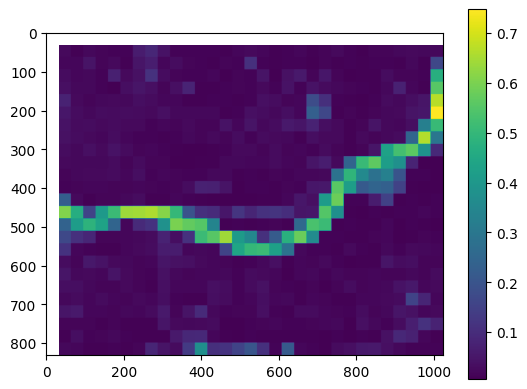

In [53]:
predicted_distances = np.asarray(predicted_distances).flatten()
change_map_image = tiles2image(predicted_distances, grid_shape = (32, 26), overlap=0, tile_size = 32)

import pylab as plt
plt.imshow(change_map_image[0])
plt.colorbar()
plt.show()

Visualization of the inputs to the network (note that we are showing just 3 out of the 10 bands, and that the data was normalised)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


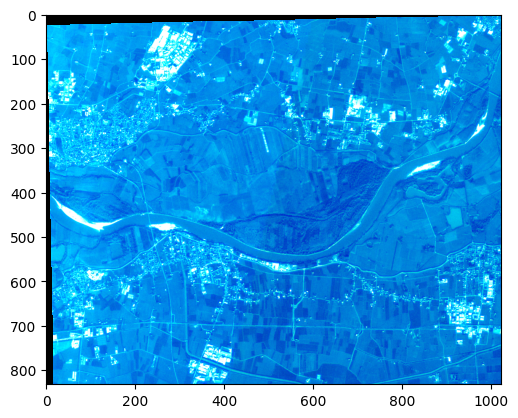

In [54]:
before_image = tiles2image(before_array, grid_shape = (32, 26), overlap=0, tile_size = 32, channels = channel)
rgb_image = before_image[[0,1,2]]

import pylab as plt
plt.imshow(np.swapaxes( np.swapaxes( rgb_image ,1,2) , -1, 0))
plt.show()
# Note that the image is normalized between -1 and 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


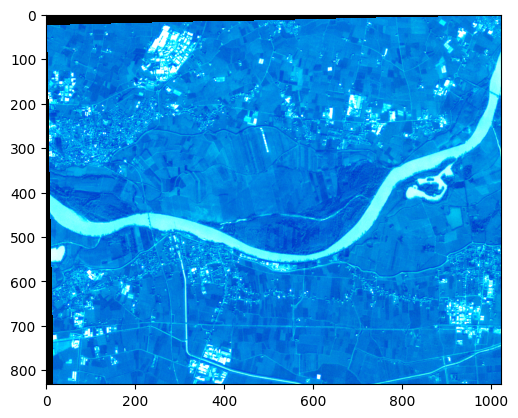

In [55]:
after_image = tiles2image(after_array, grid_shape = (32, 26), overlap=0, tile_size = 32, channels = channel)
rgb_image = after_image[[0,1,2]]

import pylab as plt
plt.imshow(np.swapaxes( np.swapaxes( rgb_image ,1,2) , -1, 0))
plt.show()
# Note that the image is normalized between -1 and 1

## Use random inputs to test software performance

In [56]:
def random_in(batch_size, input_shape, device):
    # Step 1: Create random float32 tensor
    x = torch.randn(batch_size, *input_shape, dtype=torch.float32, device=device)
    # Step 2: Normalize to [0, 1] range
    x = (x - x.min()) / (x.max() - x.min())
    # Step 3: Scale to [0, 65535] and cast to int32 (simulate uint16)
    x_uint16 = ((x * 65535).to(dtype=torch.int32) & 0xFFFF).to(dtype=torch.float32)  # Mask to 16 bits
    return x_uint16

def random_out(batch_size, input_shape, device):
    return torch.randn(batch_size, *input_shape, dtype=torch.float32).to(device)

input_shape = (channel, 32, 32)
output_shape = (1, 128)
vector_shape = (3, 128)
if channel == 10: 
  visualisation_channels = [2,1,0,3,4,5,6,7,8,9] # < all 10 high res bands, ps: keeping the same order is important
elif (channel == 4):
  visualisation_channels = [2,1,0,3] # < all 4 high res bands, ps: keeping the same order is important
model = module.model
print("Created model (empty)")
model.eval()

device = which_device(model)

# We have: model.forward .encode, .decode
batch_size = 512

number_of_batches = math.ceil(19027. / float(batch_size))

mu_lib = []

tensor_sample = random_in(batch_size, input_shape, device)
tensor_sample_normed = random_out(batch_size, input_shape, device)
mu_2 = random_out(batch_size, vector_shape, device)

# warm-up
#for i in range(3): twin_ae_change_score(model, random_sample(batch_size, input_shape, device), random_sample(batch_size, input_shape, device))

time_total = 0
if True:
    #with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    for attempt in range(number_of_batches):
        
        start_time = time.time()

        mu_1, distance = model.ravaen_encoder(tensor_sample, mu_2)
        mu_lib.append(mu_1)
            
        end_time = time.time()
        time_total += (end_time - start_time)
        if attempt == 0: print("Single evaluation took ", time_total)

print("Full evaluation took", time_total, "~ one batch in", time_total / number_of_batches)

Created model (empty)
Model is on: cpu


C:\Users\hongda\AppData\Local\Temp\ipykernel_297892\4250136096.py:162: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1773.)
  data_one_band[np.isinf(data_one_band)] = np.nan
C:\Users\hongda\AppData\Local\Temp\ipykernel_297892\4250136096.py:161: RuntimeWarning: invalid value encountered in log
  data_one_band = np.log(data_one_band)


Single evaluation took  0.0835268497467041
Full evaluation took 3.028116464614868 ~ one batch in 0.0796872753846018
